### Image Compression   
using Linear Algebra Singular Value Decomposition

In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mImage
from PIL import Image

#### Concept

Image compression is something we are all familiar as people who live in the era of social media. But how is it done?

First, let's look at an image and how it can be represented in a computing environment.

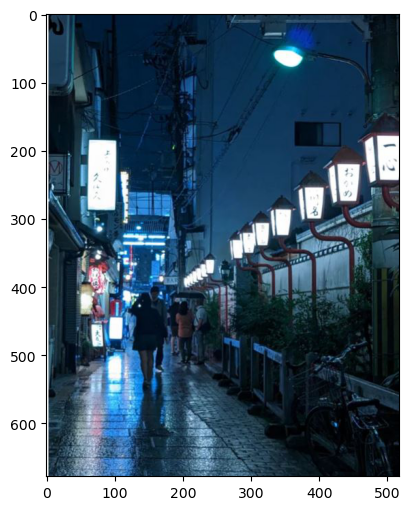

In [3]:
img = Image.open('../Figures/svd_demo.jpg')
plt.figure(figsize=(9,6))
plt.imshow(img);

Turn memories into numbers   

In [7]:
# Images come as 3D numpy arrays, 1 array for each colour channel (R, G, B)
print(f"image in array: {np.array(list(img.getdata())).shape}")
print(f"{img.size = }")

image in array: (351204, 3)
img.size = (518, 678)


In [8]:
# 0th band (R) in a numpy array with the same dimensions as the image
mat = np.array(list(img.getdata(band=0)), float).reshape(img.size[1], img.size[0])
mat

array([[255., 249., 248., ...,  26.,  24.,   9.],
       [255., 252., 251., ...,  25.,  22.,   9.],
       [254., 254., 252., ...,  31.,  28.,  13.],
       ...,
       [255., 255., 253., ...,   0.,   0.,   0.],
       [255., 255., 254., ...,   0.,   0.,   0.],
       [255., 255., 254., ...,   0.,   0.,   0.]])

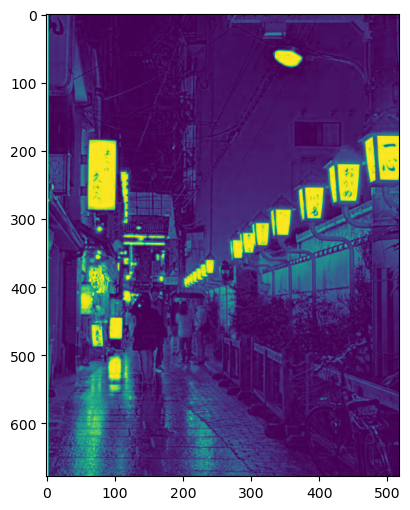

In [10]:
# Visualise the one-channel matrix as an image
plt.figure(figsize=(9,6))
plt.imshow(mat);

#### Basic Properties of Matrices    
1. Matrices can be factorised into 3 component matrices by Singular Value Decomposition (SVD): $ M = U * \Sigma * V^T $
2. Every matrix of real numbers has a Singular Value Decomposition.

In [11]:
U, sigma, VT = np.linalg.svd(mat)

#### Intuition: Compressing an Image with Truncated SVD
How to use $U$, $\Sigma$, and $VT$   

If we multiply them, we get the same image back.  

Compressing an image, we lose some resolution but still retain the essential information (shapes and colours) of the image. Similar to principal component analysis (PCA), we select a certain number ($K$) of rows and columns from each decomposed factor of the matrix. This will approximate the original matrix using the truncated SVD --> $ M_{compressed} = U_k * \Sigma_k * V^T_k $

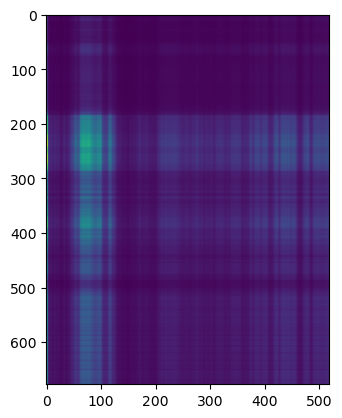

In [13]:
# Set K=1 and see the result
k = 1
uncompress = np.matrix(U[:,:k]) @ np.diag(sigma[:k]) @ np.matrix(VT[:k,:])
plt.imshow(uncompress);

In [14]:
# How many Singular Values does sigma contain?
len(sigma)

518

#### What's Sigma?   
Why is it not a matrix? Why did you apply np.diag() to it?

##### Sigma
Imagine two arrows orthogonal to each other. These two arrows represent $U$ (left singular vectors) and $V^T$ (right singular vectors).

$\Sigma$ tells you how strong the relationship is between $U$ and $V^T$.

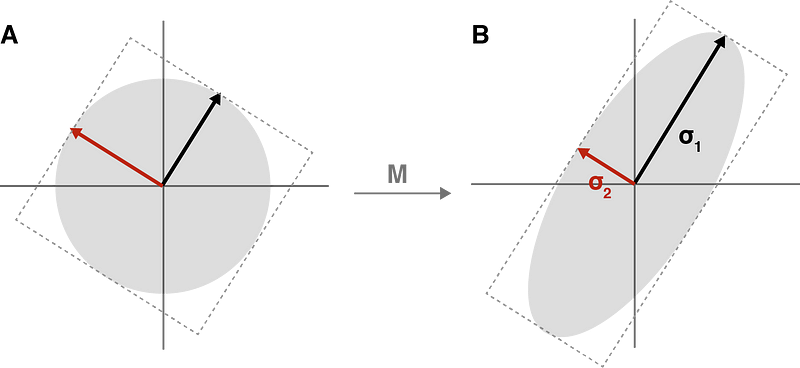

Credit: Gregory Gundersen (https://gregorygundersen.com/blog/2018/12/10/svd/)

[worked example](https://medium.com/intuition/singular-value-decomposition-svd-working-example-c2b6135673b5)


##### Why apply np.diag?

np.diag() is necessary because Sigma is meant to be a diagonal matrix, e.g.:

$ \begin{matrix}
8 & 0 & 0 \\
0 & 4 & 0 \\
0 & 0 & 3 
\end{matrix}  $

Since $M_{compressed} = U_k * \Sigma_k * V^T_k$...

and M is a matrix with dimensions (2980, 2250)...

$\underset{{(2980,k)}}{U_k} * \underset{{(k,k)}}{\Sigma_k} * \underset{{(k,2250)}}{V^T_k} = \underset{{(2980,2250)}}{M_{compressed}}$

Therefore, you must apply np.diag() on Sigma to make it (k,k) dimensions.

##### Why is Sigma not a matrix?   
As output by Numpy, Sigma is a 1D vector.  

Say the image from my below-average phone camera is 2980 x 2250 matrix. A diagonal Sigma matrix has to be (2250, 2250) in shape with a lot of 0 values. This sparse matrix has 5,062,500 values (0.6 to 1 MB) and is very expensive and wasteful to hold in memory or storage for no additional information gained.   

##### Compression   
The first value of Sigma is always the largest. The same goes for $U$ and $V^T$. By selecting the first K of each and multiplying them together, we can reconstruct the images in varying levels of detail.

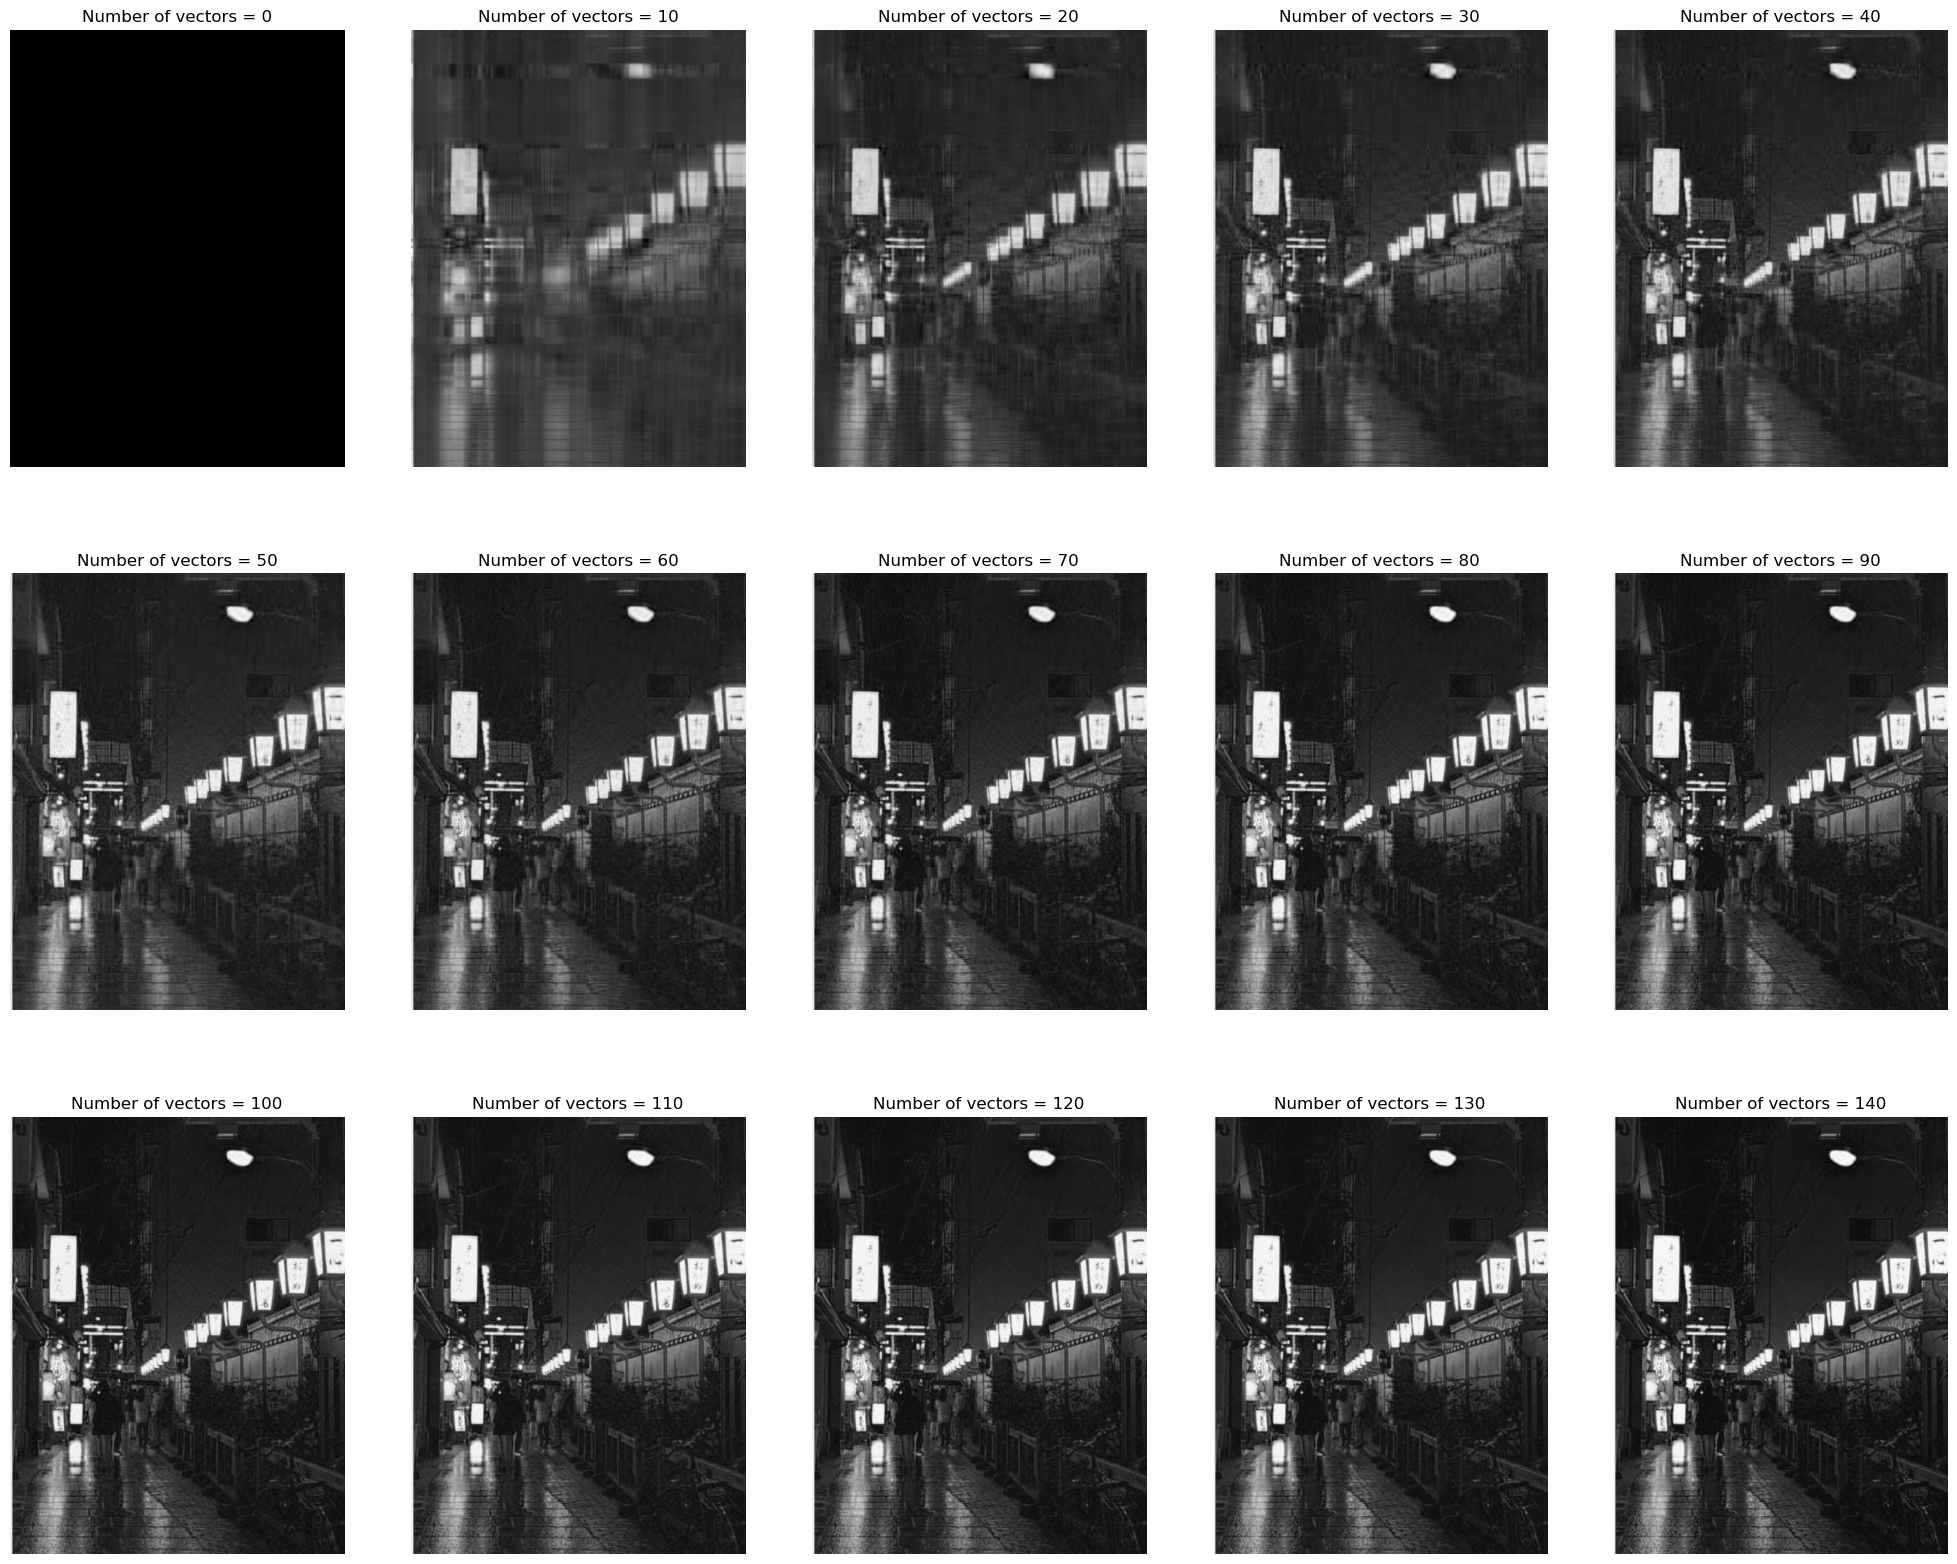

In [15]:
limit = 5
max_vectors = 150
step = 10
fig, ax = plt.subplots(int(max_vectors/step/limit), limit, figsize=(25, 20))

curr_fig=0
for k in range(0, max_vectors, step):
    uncompress = np.matrix(U[:,:k]) @ np.diag(sigma[:k]) @ np.matrix(VT[:k,:])
    title = f"Number of vectors = {k}"
    fignum = int(curr_fig/limit)
    subplot_num = curr_fig%limit
    ax[fignum][subplot_num].imshow(uncompress, cmap='gray',)
    ax[fignum][subplot_num].set_title(title)
    ax[fignum,subplot_num].axis('off')
    curr_fig += 1
plt.show()
    

##### Compression successful

We have managed to compress the image successfully using only x of the original n vectors.

The current image's percentage of the original image size:

In [16]:
# Check compressed image vs. original image size
original_size = np.product(mat.shape)

chosen_k = 140
compressed_size = chosen_k/len(sigma) * mat.shape[0] + chosen_k + chosen_k/len(sigma) * mat.shape[1]
compressed_size/original_size * 100

0.13190147129396113

Try the same for a coloured image. 

In [17]:
def compress_image(U, S, VT, k):
    return (U[:,:k] @ np.diag(S[:k])) @ VT[:k]

In [18]:
# Read the image in as a 3-dimensional array (3 dimensions corresponding to the R, G, B colour channels)
A = mImage.imread('../Figures/svd_demo.jpg')
A

array([[[255, 254, 255],
        [249, 250, 255],
        [248, 251, 255],
        ...,
        [ 26,  44,  54],
        [ 24,  42,  54],
        [  9,  27,  41]],

       [[255, 254, 255],
        [252, 253, 255],
        [251, 254, 255],
        ...,
        [ 25,  43,  53],
        [ 22,  40,  52],
        [  9,  27,  41]],

       [[254, 253, 255],
        [254, 255, 255],
        [252, 255, 255],
        ...,
        [ 31,  48,  56],
        [ 28,  45,  55],
        [ 13,  29,  42]],

       ...,

       [[255, 252, 249],
        [255, 254, 253],
        [253, 254, 255],
        ...,
        [  0,   1,   5],
        [  0,   1,   5],
        [  0,   1,   5]],

       [[255, 250, 247],
        [255, 254, 253],
        [254, 255, 255],
        ...,
        [  0,   1,   5],
        [  0,   1,   5],
        [  0,   1,   5]],

       [[255, 250, 247],
        [255, 254, 253],
        [254, 255, 255],
        ...,
        [  0,   1,   5],
        [  0,   1,   5],
        [  0,   1,   5]]

In [19]:
# Normalise the image matrices so that all values lie within range 0.0 to 1.0
R = A[:,:,0] / 255
G = A[:,:,1] / 255
B = A[:,:,2] / 255

In [20]:
# Get the SVD vectors of the 3 colour channels
R_U, R_S, R_VT = np.linalg.svd(R)
G_U, G_S, G_VT = np.linalg.svd(G)
B_U, B_S, B_VT = np.linalg.svd(B)

In [21]:
def compress_by_rank(relative_rank:float=1.0):
    """
    This function compresses my Osaka image by "relative_rank". 
    Basically, this parameter stands for how many % of the data do you want to use.
    """
    assert 0.0 <= relative_rank <= 1.0, "Relative rank must be a number between 0.0 and 1.0!"
    max_rank = int(relative_rank * min(R.shape[0], R.shape[1]))
    print("max rank = %d" % max_rank)
    R_comp = compress_image(R_U, R_S, R_VT, max_rank)
    G_comp = compress_image(G_U, G_S, G_VT, max_rank)
    B_comp = compress_image(B_U, B_S, B_VT, max_rank)
    compressed_float = np.dstack((R_comp, G_comp, B_comp))
    compressed = (np.minimum(compressed_float, 1.0) * 255).astype(np.uint8)
    return compressed

max rank = 5


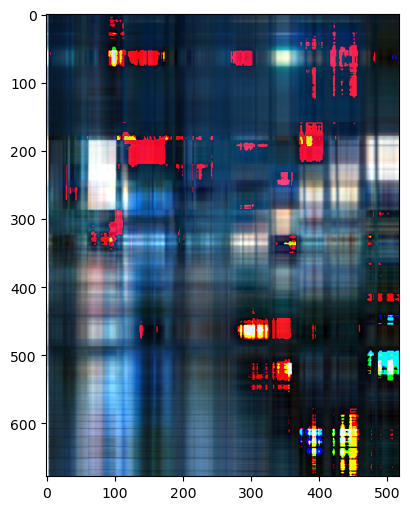

In [22]:
# Test 1% of the data
compressed = compress_by_rank(0.01)
plt.figure(figsize=(9,6))
plt.imshow(compressed)

max rank = 25


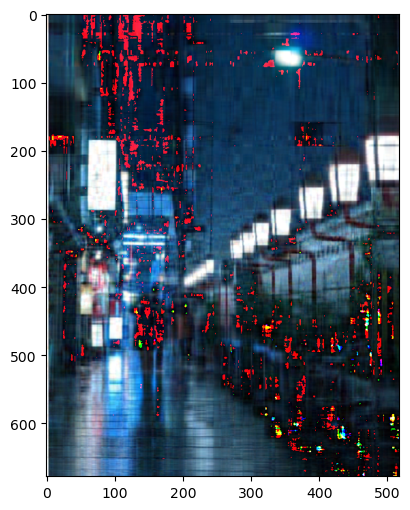

In [23]:
compressed = compress_by_rank(0.05)
plt.figure(figsize=(9,6))
plt.imshow(compressed);

max rank = 51


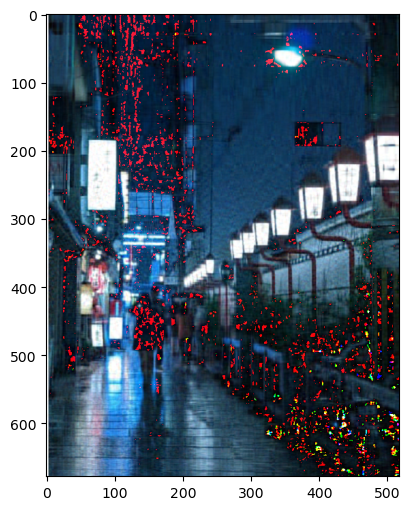

In [24]:
compressed = compress_by_rank(0.10)
plt.figure(figsize=(9,6))
plt.imshow(compressed);

Lots of red and yellow spots around. The image is still very noisy. Let's try 20% of the data.

max rank = 103


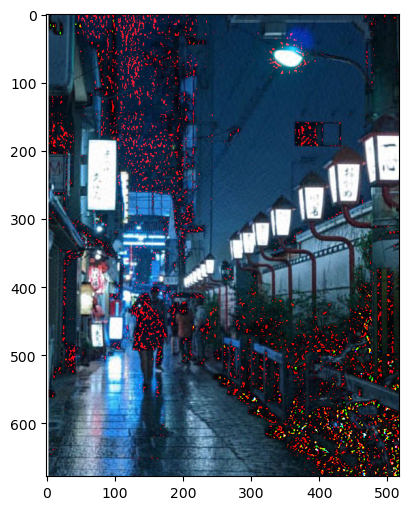

In [25]:
compressed = compress_by_rank(0.20)
plt.figure(figsize=(9,6))
plt.imshow(compressed);

There are still noticeable spots. Let's try 40%.

max rank = 207


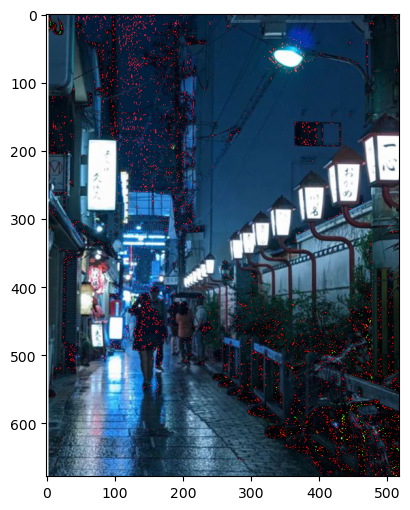

In [26]:
compressed = compress_by_rank(0.40)
plt.figure(figsize=(9,6))
plt.imshow(compressed);

#### Finding the best K or best relative rank    

We need more vectors to get a nice coloured image with no red or green spots. This is a big difference from greyscale, where just 100 could produce an acceptable image. 

#### Objective vs. Heuristic Compression   

We've managed to find some sweet spots (900 for colour images) by trial and error.

Is there a mathematical, objective way to find the exact rank that minimises the error and maximises the compression?

Yes!

In [27]:
def find_best_k(target_err:float, S:np.ndarray):
    """
    Finds best K from a given Sigma array
    """
    assert 0.0 <= target_err <= 1.0
    squared_err = S**2                  # Sigma is already from largest to smallest... [8, 4, 0]... square it --> [64, 16, 0]
    sorted_err = squared_err[::-1]      # Sort Sigma so that the smallest error will be first and the largest will be last... [0, 16, 64]
    ranks = np.cumsum(sorted_err)[::-1] # Sum all the errors cumulative from smallest to largest... [0, 16, 80]... then reverse them... [80, 16, 0] --> get a list of descending squared error values
    sq_rel_err = ranks/ranks[0]         # Divide all the squared errors by the largest squared error. This lets us find the point at which the error drops sufficiently to meet the target error.
    rel_error = np.sqrt(sq_rel_err)     # Square root all the errors so they can be compared to target error
    return np.min(np.where(rel_error < target_err)) # Get the smallest value of K that meets the targeted error

In [28]:
def compress_by_best_rank(target_err=0.10):
    """
    This function finds the best K for each colour channel.
    """
    best_R_k = find_best_k(target_err, R_S)
    best_G_k = find_best_k(target_err, G_S)
    best_B_k = find_best_k(target_err, B_S)
    print(f'Best K --- R:{best_R_k} | G:{best_G_k} | B:{best_B_k}')
    
    R_comp = compress_image(R_U, R_S, R_VT, best_R_k)
    G_comp = compress_image(G_U, G_S, G_VT, best_G_k)
    B_comp = compress_image(B_U, B_S, B_VT, best_B_k)
    compressed_float = np.dstack((R_comp, G_comp, B_comp))
    compressed = (np.minimum(compressed_float, 1.0) * 255).astype(np.uint8)
    return compressed

Best K --- R:130 | G:110 | B:93


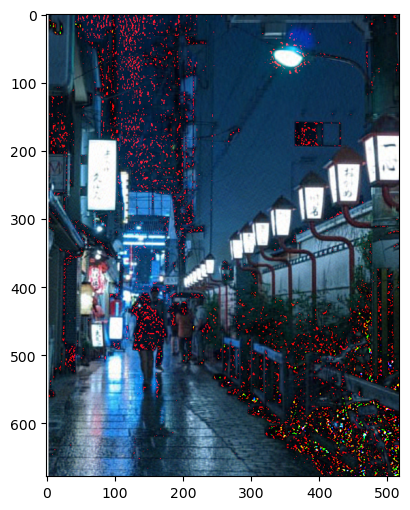

In [29]:
# Let's try allowing 5% error
compressed = compress_by_best_rank(0.05)
plt.figure(figsize=(9,6))
plt.imshow(compressed)

Best K --- R:222 | G:200 | B:183


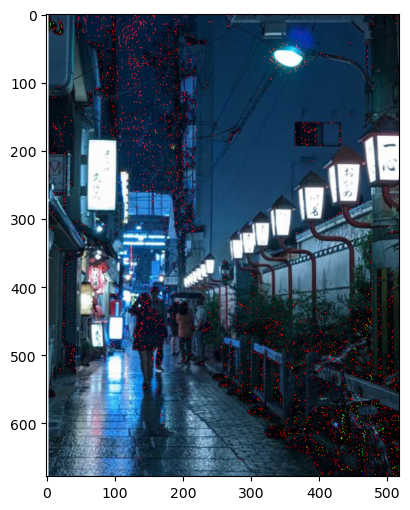

In [30]:
# Hmm. Still lots of red and green spots. 
# Let's target 2% relative error
compressed = compress_by_best_rank(0.02)
plt.figure(figsize=(9,6))
plt.imshow(compressed)

Best K --- R:286 | G:265 | B:250


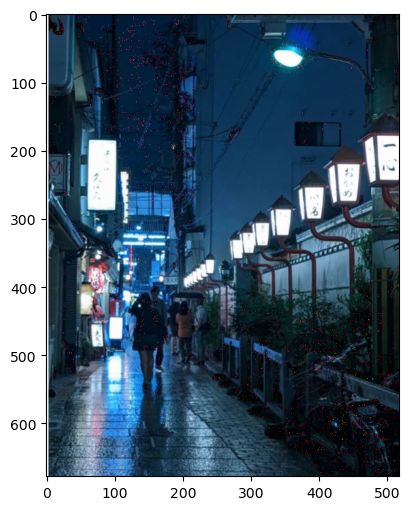

In [31]:
# There are still obvious red and green spots!
# Let's finally target 1% relative error
compressed = compress_by_best_rank(0.01)
plt.figure(figsize=(9,6))
plt.imshow(compressed)

#### Conclusion
1. Compression saves a ton of space vs. the original data (99% is possible)
2. It's also possible to compress a colour image in the same way, but you need to do the same process for all 3 colour channels.
3. There is an objective, mathematical way to find the best number of vectors for minimising error to your desired level while maximising the compression effect.
4. It's much easier to compress a greyscale image than a coloured image! The optimal K may differ for each colour channel, and low mathematical error does not mean an acceptable image to the human eye.

##### References:

1. https://zerobone.net/blog/cs/svd-image-compression/
2. https://www.frankcleary.com/svdimage/
3. https://medium.com/intuition/singular-value-decomposition-svd-working-example-c2b6135673b5
4. https://gregorygundersen.com/blog/2018/12/10/svd/
